In [2]:
# !pip install xgboost

In [3]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

### Import libraries

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import sys
import datetime
from datetime import date, timedelta
from tqdm.notebook import tqdm
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [5]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 10)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,WINTER
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1,WINTER
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2,WINTER
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3,WINTER
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4,WINTER


In [6]:
weather_df = pd.read_csv('../../dataset/Weather/mysuru_kodagu_hassan_weather.csv')
print(weather_df.shape)
weather_df.head()

(12783, 35)


,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,0,0,0


In [7]:
weather_df['YYYY'] = weather_df['date'].str[:4].astype(int)
weather_df['MM'] = weather_df['date'].str[5:7].astype(int)
weather_df['DD'] = weather_df['date'].str[8:].astype(int)
weather_df

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,2010,1,1
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,2010,1,1
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,2010,1,1
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,2010,1,2
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,2010,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12778,2021-08-30,Kodagu,20.07,20.57,19.03,23.77,1009.00,93.50,1.71,241.83,...,0,0,0,0,0,0,0,2021,8,30
12779,2021-08-30,Mysuru,22.36,22.90,19.59,28.21,1009.33,82.33,5.38,253.62,...,0,0,0,0,0,0,0,2021,8,30
12780,2021-08-31,Hassan,21.86,22.21,18.87,26.31,1009.29,82.17,3.39,249.33,...,0,0,0,0,0,0,0,2021,8,31
12781,2021-08-31,Kodagu,21.29,21.81,19.03,26.23,1009.79,89.21,1.78,245.88,...,0,0,0,0,0,0,0,2021,8,31


In [8]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

print(kodagu_df.shape, hassan_df.shape, mysuru_df.shape)

(4261, 38) (4261, 38) (4261, 38)


### Check Coorelation

In [9]:
m = mysuru_df.copy()
m = m.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert m.shape[0] == 4261
m.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Mysuru,23.21,23.24,16.74,29.32,1014.58,64.33,2.19,71.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
h = hassan_df.copy()
h = h.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert h.shape[0] == 4261
h.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
k = kodagu_df.copy()
k = k.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert k.shape[0] == 4261
k.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


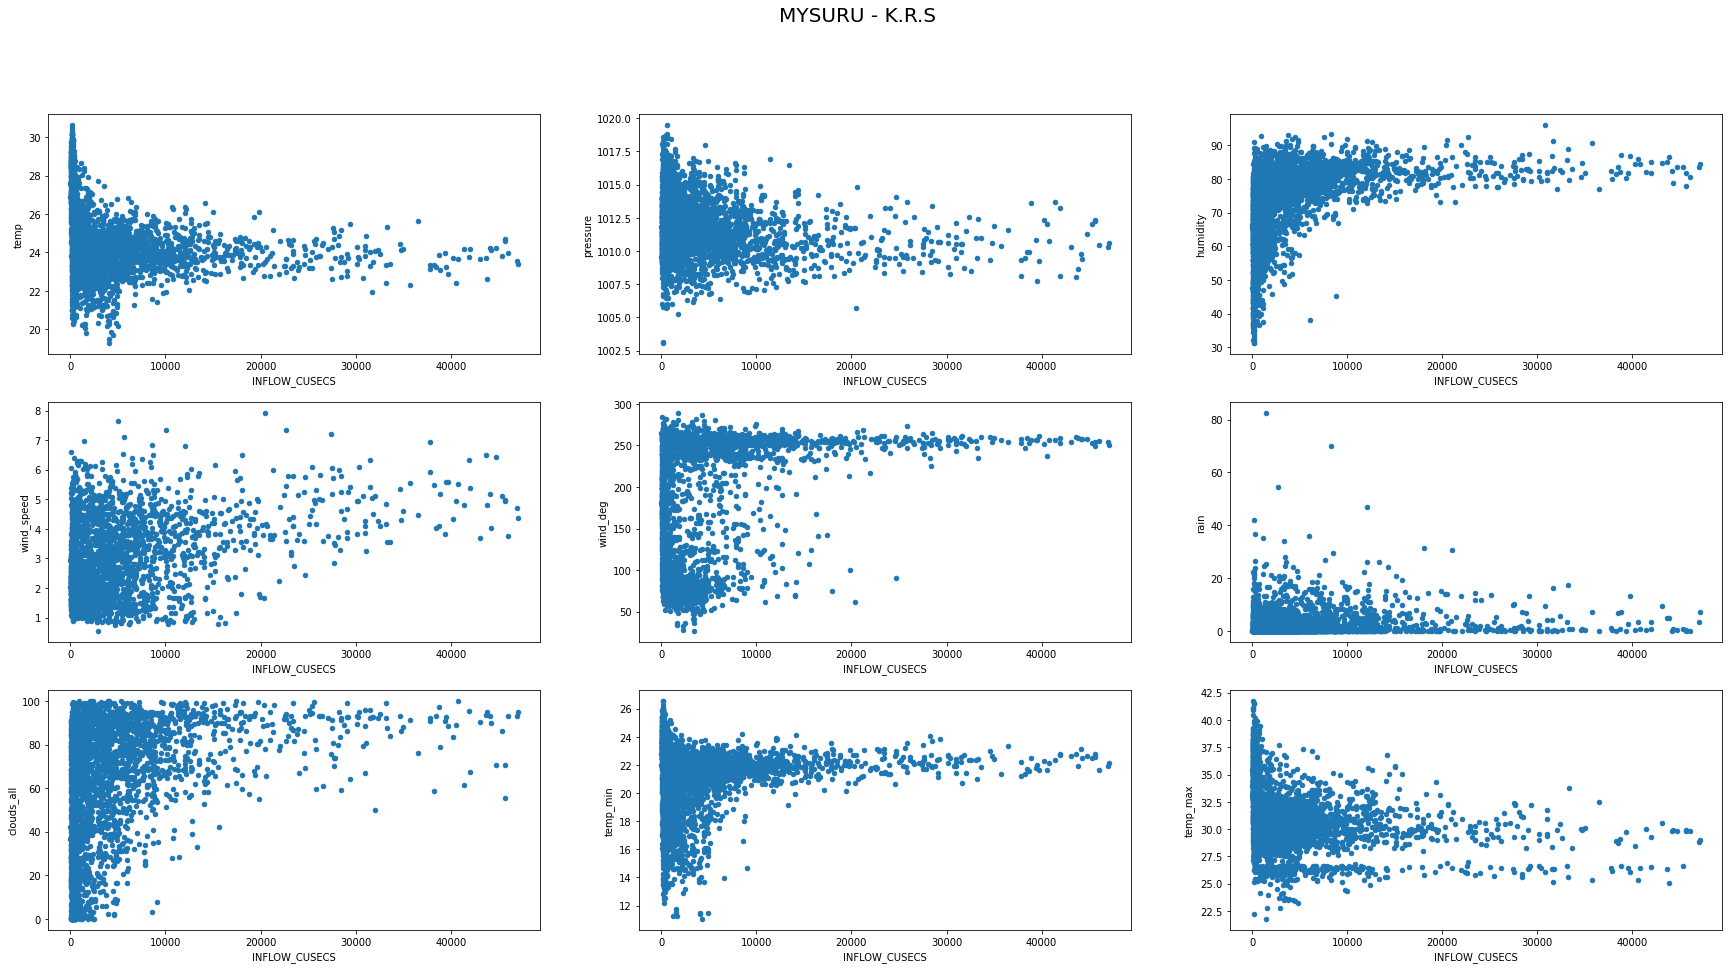

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
m.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
m.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
m.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
m.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
m.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('MYSURU - K.R.S', fontsize=20)
plt.show()

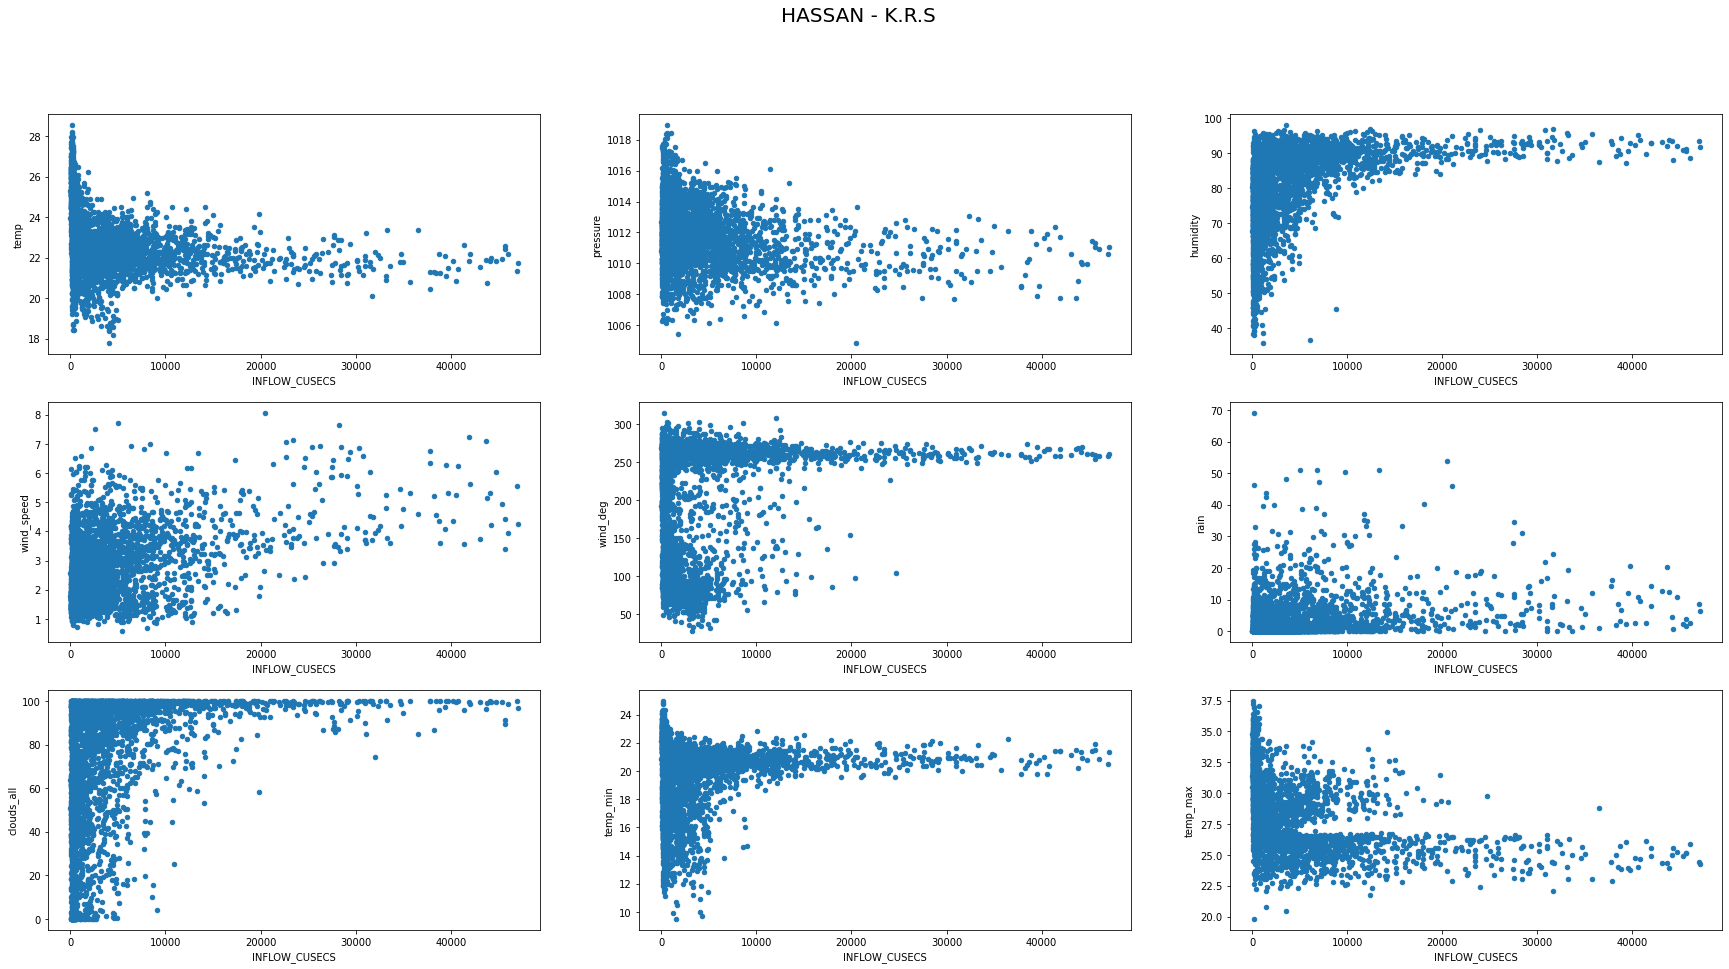

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
h.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
h.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
h.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
h.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
h.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('HASSAN - K.R.S', fontsize=20)
plt.show()

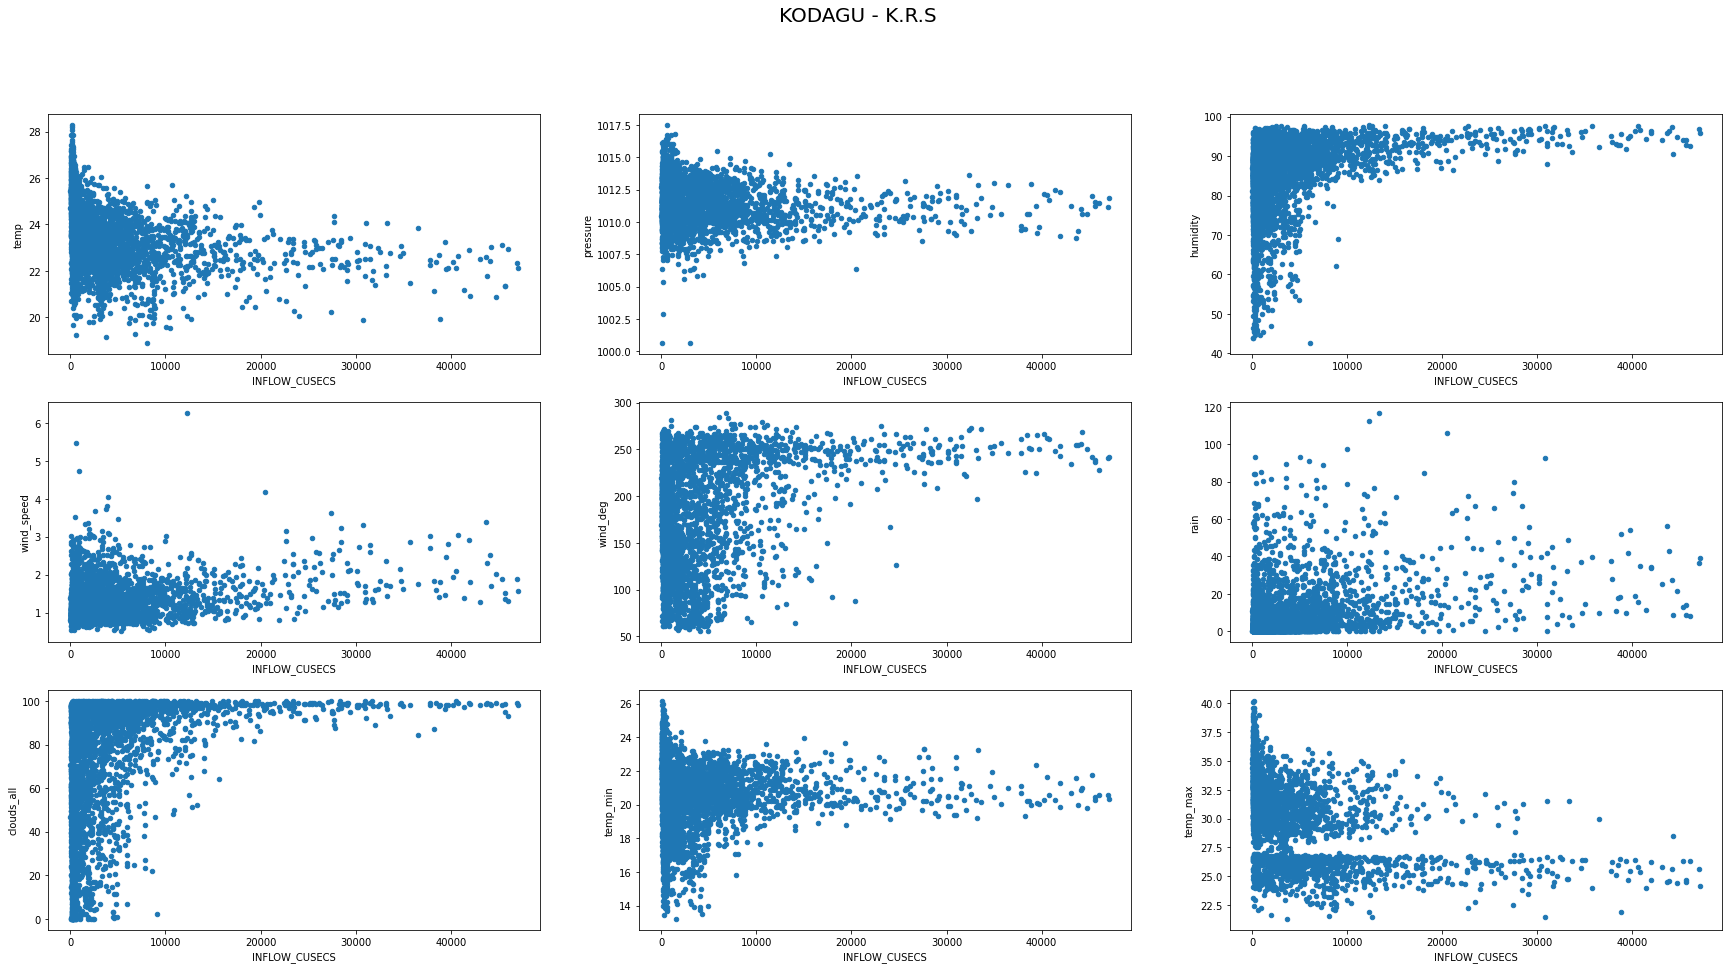

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
k.plot(x='INFLOW_CUSECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
k.plot(x='INFLOW_CUSECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
k.plot(x='INFLOW_CUSECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
k.plot(x='INFLOW_CUSECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
k.plot(x='INFLOW_CUSECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('KODAGU - K.R.S', fontsize=20)
plt.show()

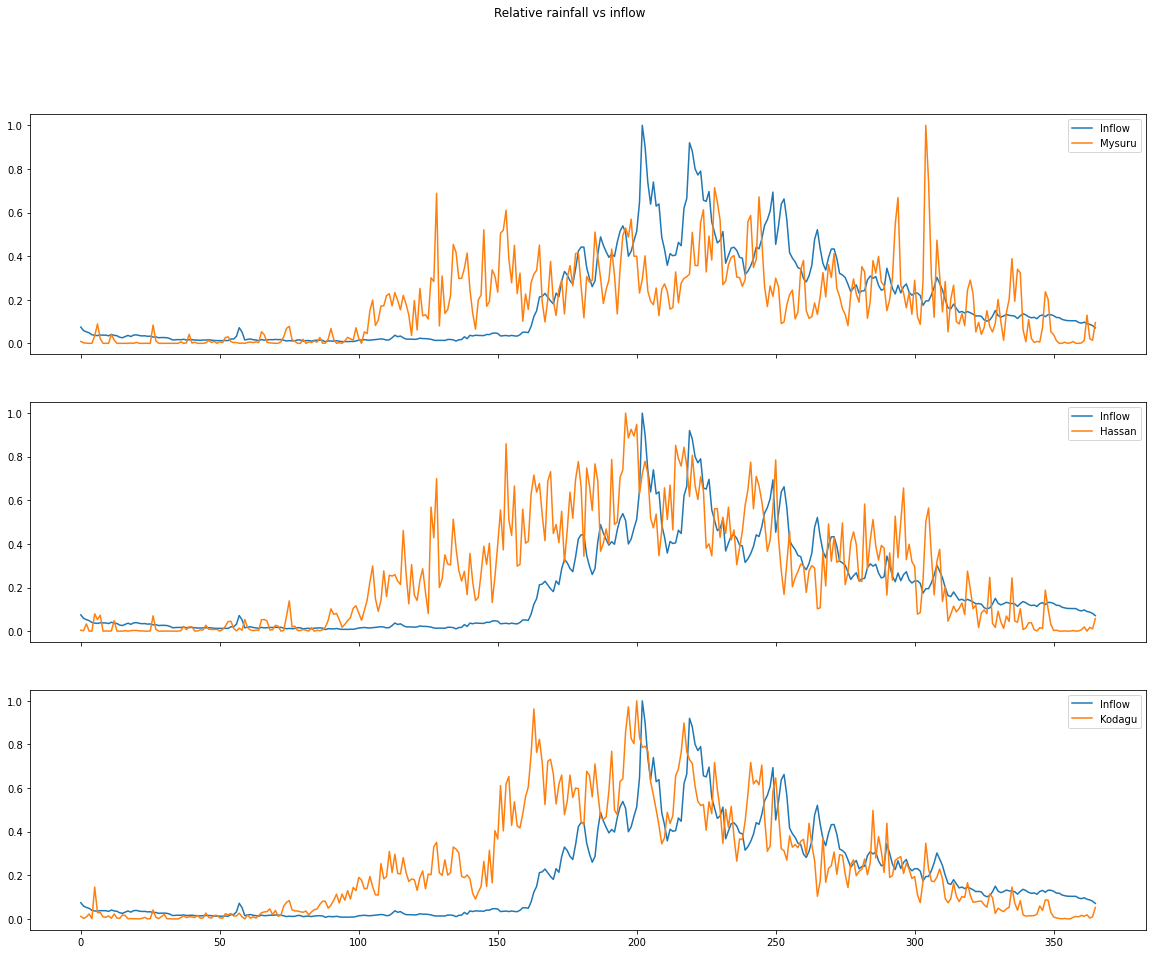

In [15]:
m.rename(columns={'rain': 'mysuru_rain'}, inplace=True)
h.rename(columns={'rain': 'hassan_rain'}, inplace=True)
k.rename(columns={'rain': 'kodagu_rain'}, inplace=True)
t = m[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'mysuru_rain']].merge(h[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'hassan_rain']], on=['YYYY', 'DD', 'MM', 'INFLOW_CUSECS'], how='inner').merge(k[['YYYY', 'DD', 'MM', 'INFLOW_CUSECS', 'kodagu_rain']], on=['YYYY', 'DD', 'MM', 'INFLOW_CUSECS'], how='inner')
g = t.groupby(['MM', 'DD'])[['INFLOW_CUSECS', 'mysuru_rain', 'hassan_rain', 'kodagu_rain']].mean()

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(20, 15))
ax[0].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[0].plot(range(g.shape[0]), g['mysuru_rain'].values / g['mysuru_rain'].max(), label='Mysuru')
ax[1].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[1].plot(range(g.shape[0]), g['hassan_rain'].values / g['hassan_rain'].max(), label='Hassan')
ax[2].plot(range(g.shape[0]), g['INFLOW_CUSECS'].values / g['INFLOW_CUSECS'].max(), label='Inflow')
ax[2].plot(range(g.shape[0]), g['kodagu_rain'].values / g['kodagu_rain'].max(), label='Kodagu')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.suptitle('Relative rainfall vs inflow')
plt.show()

### Dataset Transformation

In [16]:
inflow_df = inflow_df[['INFLOW_CUSECS', 'YEAR', 'MONTH', 'DATE', 'SEASON']]
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,2029.0,2011,1,1,WINTER
1,3084.0,2011,1,2,WINTER
2,2776.0,2011,1,3,WINTER
3,2311.0,2011,1,4,WINTER
4,1847.0,2011,1,5,WINTER


In [17]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(inflow_df['SEASON'].unique())

In [18]:
rs_inflow = RobustScaler().fit(inflow_df[['INFLOW_CUSECS']])
rs_temp = RobustScaler().fit(weather_df[['temp']])
rs_feels_like = RobustScaler().fit(weather_df[['feels_like']])
rs_temp_min = RobustScaler().fit(weather_df[['temp_min']])
rs_temp_max = RobustScaler().fit(weather_df[['temp_max']])
rs_pressure = RobustScaler().fit(weather_df[['pressure']])
rs_humidity = RobustScaler().fit(weather_df[['humidity']])
rs_wind_speed = RobustScaler().fit(weather_df[['wind_speed']])
rs_wind_deg = RobustScaler().fit(weather_df[['wind_deg']])
rs_rain = RobustScaler().fit(weather_df[['rain']])
rs_clouds_all = RobustScaler().fit(weather_df[['clouds_all']])
# remaining columns will be divided by 24 for scaling purpose.

In [19]:
inflow_df['INFLOW_CUSECS'] = rs_inflow.transform(inflow_df[['INFLOW_CUSECS']]).flatten()
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,0.073551,2011,1,1,WINTER
1,0.289397,2011,1,2,WINTER
2,0.226382,2011,1,3,WINTER
3,0.131246,2011,1,4,WINTER
4,0.036315,2011,1,5,WINTER


In [20]:
inflow_df['date'] = pd.to_datetime(inflow_df['YEAR'].astype(str) + '-' + inflow_df['MONTH'].astype(str) + '-' + inflow_df['DATE'].astype(str))
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON,date
0,0.073551,2011,1,1,WINTER,2011-01-01
1,0.289397,2011,1,2,WINTER,2011-01-02
2,0.226382,2011,1,3,WINTER,2011-01-03
3,0.131246,2011,1,4,WINTER,2011-01-04
4,0.036315,2011,1,5,WINTER,2011-01-05


In [21]:
weather_df.columns

Index(['date', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain', 'clouds_all',
       'broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm',
       'YYYY', 'MM', 'DD'],
      dtype='object')

In [22]:
weather_df['temp'] = rs_temp.transform(weather_df[['temp']]).flatten()
weather_df['feels_like'] = rs_feels_like.transform(weather_df[['feels_like']]).flatten()
weather_df['temp_min'] = rs_temp_min.transform(weather_df[['temp_min']]).flatten()
weather_df['temp_max'] = rs_temp_max.transform(weather_df[['temp_max']]).flatten()
weather_df['pressure'] = rs_pressure.transform(weather_df[['pressure']]).flatten()
weather_df['humidity'] = rs_humidity.transform(weather_df[['humidity']]).flatten()
weather_df['wind_speed'] = rs_wind_speed.transform(weather_df[['wind_speed']]).flatten()
weather_df['wind_deg'] = rs_wind_deg.transform(weather_df[['wind_deg']]).flatten()
weather_df['rain'] = rs_rain.transform(weather_df[['rain']]).flatten()
weather_df['clouds_all'] = rs_clouds_all.transform(weather_df[['clouds_all']]).flatten()
weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] = weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] / 24

In [23]:
weather_df.head()

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,-0.736,-0.737201,-1.281690,-0.657143,0.683274,-0.156784,0.559748,-0.826564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
1,2010-01-01,Kodagu,0.116,0.180887,-0.281690,0.242857,0.209964,0.161345,-0.232704,-0.714651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
2,2010-01-01,Mysuru,0.228,0.112628,-0.718310,0.048214,0.476868,-0.698404,0.440252,-0.818667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
3,2010-01-02,Hassan,-1.152,-1.153584,-2.250000,-0.478571,1.306050,-0.394527,0.314465,-0.969765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2
4,2010-01-02,Kodagu,-0.020,0.078498,-0.591549,0.330357,0.889680,-0.130559,-0.320755,-0.652602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2


In [24]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

In [25]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020].reset_index(drop=True)
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020].reset_index(drop=True)

train_inflow_df.shape, val_inflow_df.shape

((2944, 6), (330, 6))

In [26]:
def embed_day(df):
    data = {}
    for index in tqdm(df.index):
        row = df.iloc[index]
        inflow = row['INFLOW_CUSECS']
        year = row['YEAR']
        month = row['MONTH']
        date = row['DATE']
        season = row['SEASON']

        ddmmyyyy = datetime.date(year, month, date)
        ddmmyyyy_list = [str(ddmmyyyy + timedelta(days=day)) for day in range(-10, 1)]
        prev_ddmmyyyy_list = [str(ddmmyyyy + timedelta(days=day)) for day in range(-10, 0)]

        sel_kodagu = kodagu_df[kodagu_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_hassan = hassan_df[hassan_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_mysuru = mysuru_df[mysuru_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_inflow = inflow_df[inflow_df['date'].isin(prev_ddmmyyyy_list)]['INFLOW_CUSECS'].values.flatten()
        
        if sel_inflow.shape[0] != len(prev_ddmmyyyy_list):
            continue

        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])
#         month_transformed = month_oe.transform([[month]]).toarray().flatten()
#         date_transformed = date_oe.transform([[date]]).toarray().flatten()
#         season_transformed = season_oe.transform([[season]]).toarray().flatten()
        
#         data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, [inflow]])
        data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, sel_kodagu, sel_hassan, sel_inflow, [inflow]])
    return pd.DataFrame(data).T

In [27]:
train_emb_df = embed_day(train_inflow_df)
val_emb_df = embed_day(val_inflow_df)

In [28]:
train_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
2011-01-11,0.0,10.0,2.0,-0.680,-0.638225,-1.218310,-0.296429,-0.576512,-0.173888,-0.597484,...,0.289397,0.226382,0.131246,0.036315,0.099535,0.036315,0.068027,-0.027109,-0.058821,-0.090328
2011-01-12,0.0,11.0,2.0,-0.640,-0.593857,-1.151408,-0.189286,-0.412811,-0.031357,-0.528302,...,0.226382,0.131246,0.036315,0.099535,0.036315,0.068027,-0.027109,-0.058821,-0.090328,-0.028541
2011-01-13,0.0,12.0,2.0,-0.480,-0.464164,-0.679577,-0.350000,-0.014235,-0.059863,0.157233,...,0.131246,0.036315,0.099535,0.036315,0.068027,-0.027109,-0.058821,-0.090328,-0.028541,-0.028541
2011-01-14,0.0,13.0,2.0,-0.444,-0.477816,-0.665493,-0.326786,0.088968,-0.320981,0.345912,...,0.036315,0.099535,0.036315,0.068027,-0.027109,-0.058821,-0.090328,-0.028541,-0.028541,-0.000511
2011-01-15,0.0,14.0,2.0,-0.584,-0.600683,-0.591549,-0.664286,-0.071174,-0.209236,0.169811,...,0.099535,0.036315,0.068027,-0.027109,-0.058821,-0.090328,-0.028541,-0.028541,-0.000511,-0.099330


In [29]:
X_train, y_train = train_emb_df.values[:, :-1], train_emb_df.values[:, -1]
X_val, y_val = val_emb_df.values[:, :-1], val_emb_df.values[:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2800, 1102), (2800,), (310, 1102), (310,))

### Model Training

In [29]:
%%time
model = XGBRegressor(n_estimators=200,
                     learning_rate=0.06,
                     max_depth=3,
                     subsample=0.8,
                     random_state=0)

model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_val, y_val)])

/home/santanu/python-all/lib/python3.7/site-packages/xgboost/data.py:121: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[0]	validation_0-rmse:1.18852	validation_1-rmse:0.89566
[1]	validation_0-rmse:1.12912	validation_1-rmse:0.85242
[2]	validation_0-rmse:1.07191	validation_1-rmse:0.81000
[3]	validation_0-rmse:1.02104	validation_1-rmse:0.77057
[4]	validation_0-rmse:0.97188	validation_1-rmse:0.73441
[5]	validation_0-rmse:0.92563	validation_1-rmse:0.69819
[6]	validation_0-rmse:0.88256	validation_1-rmse:0.66672
[7]	validation_0-rmse:0.84294	validation_1-rmse:0.63868
[8]	validation_0-rmse:0.80616	validation_1-rmse:0.61335
[9]	validation_0-rmse:0.77118	validation_1-rmse:0.58768
[10]	validation_0-rmse:0.73881	validation_1-rmse:0.56443
[11]	validation_0-rmse:0.70858	validation_1-rmse:0.54536
[12]	validation_0-rmse:0.68048	validation_1-rmse:0.52553
[13]	validation_0-rmse:0.65415	validation_1-rmse:0.50905
[14]	validation_0-rmse:0.62898	validation_1-rmse:0.49523
[15]	validation_0-rmse:0.60543	validation_1-rmse:0.47869
[16]	validation_0-rmse:0.58332	validation_1-rmse:0.46571
[17]	validation_0-rmse:0.56337	validation

[144]	validation_0-rmse:0.20605	validation_1-rmse:0.29501
[145]	validation_0-rmse:0.20560	validation_1-rmse:0.29509
[146]	validation_0-rmse:0.20519	validation_1-rmse:0.29501
[147]	validation_0-rmse:0.20488	validation_1-rmse:0.29445
[148]	validation_0-rmse:0.20451	validation_1-rmse:0.29458
[149]	validation_0-rmse:0.20386	validation_1-rmse:0.29451
[150]	validation_0-rmse:0.20326	validation_1-rmse:0.29479
[151]	validation_0-rmse:0.20294	validation_1-rmse:0.29494
[152]	validation_0-rmse:0.20254	validation_1-rmse:0.29444
[153]	validation_0-rmse:0.20193	validation_1-rmse:0.29510
[154]	validation_0-rmse:0.20137	validation_1-rmse:0.29508
[155]	validation_0-rmse:0.20052	validation_1-rmse:0.29509
[156]	validation_0-rmse:0.20020	validation_1-rmse:0.29449
[157]	validation_0-rmse:0.19961	validation_1-rmse:0.29501
[158]	validation_0-rmse:0.19937	validation_1-rmse:0.29505
[159]	validation_0-rmse:0.19914	validation_1-rmse:0.29504
[160]	validation_0-rmse:0.19859	validation_1-rmse:0.29488
[161]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
# model = GradientBoostingRegressor(max_depth=10, random_state=0)
# model.fit(X_train, y_train)
#[132]	validation_0-rmse:0.02216	validation_1-rmse:0.47950

In [31]:
# model = RandomForestRegressor(max_depth=10, random_state=0)
# model.fit(X_train, y_train)

In [32]:
# model = SVR(degree=10)
# model.fit(X_train, y_train)

In [33]:
train_predictions = model.predict(X_train)
print("Train R2 score:", r2_score(y_train, train_predictions))
test_predictions = model.predict(X_val)
print("Test R2 score:", r2_score(y_val, test_predictions))

Train R2 score: 0.9789361095088404
Test R2 score: 0.900954353556058


### Predict and check Loss

In [34]:
y_pred_train = model.predict(X_train)
y_pred_train = rs_inflow.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_train_inv_trf = rs_inflow.inverse_transform(y_train.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_train_inv_trf, y_pred_train)
loss

786633.4965699745

In [35]:
y_pred_test = model.predict(X_val)
y_pred_test = rs_inflow.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_val_inv_trf = rs_inflow.inverse_transform(y_val.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_val_inv_trf, y_pred_test)
loss

2000836.525844707

### Compare Prediction on Test data

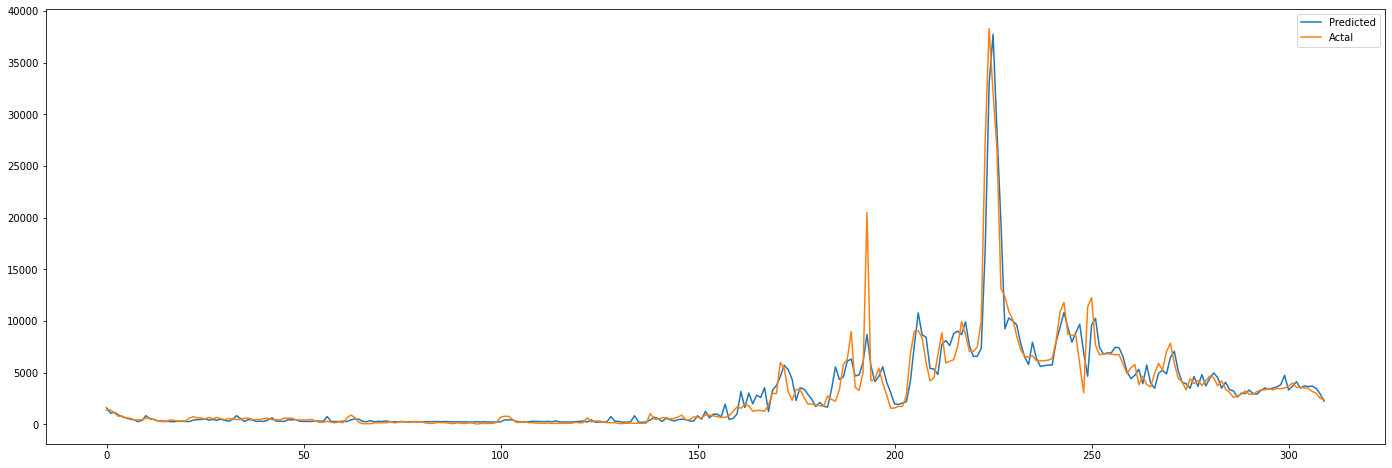

In [36]:
plt.figure(figsize=(24,8))
plt.plot(y_pred_test, label='Predicted')
plt.plot(y_val_inv_trf, label='Actal')
plt.legend()
plt.show()

### Compare Prediction on Entire data

In [37]:
model_pred_df = pd.concat([train_emb_df, val_emb_df])
model_pred_df['Predicted_Inflow'] = np.concatenate([y_pred_train, y_pred_test])
model_pred_df['INFLOW_CUSECS'] = np.concatenate([y_train_inv_trf, y_val_inv_trf])
model_pred_df.reset_index(inplace=True)
model_pred_df['index'] = pd.to_datetime(model_pred_df['index'])
model_pred_df['MONTH'] = model_pred_df['index'].dt.month
model_pred_df['DATE'] = model_pred_df['index'].dt.day
model_pred_df['YEAR'] = model_pred_df['index'].dt.year
model_pred_df

,index,0,1,2,3,4,5,6,7,8,...,1098,1099,1100,1101,1102,Predicted_Inflow,INFLOW_CUSECS,MONTH,DATE,YEAR
0,2011-01-11,0.0,10.0,2.0,-0.680,-0.638225,-1.218310,-0.296429,-0.576512,-0.173888,...,0.036315,0.068027,-0.027109,-0.058821,-0.090328,1044.158936,1228.0,1,11,2011
1,2011-01-12,0.0,11.0,2.0,-0.640,-0.593857,-1.151408,-0.189286,-0.412811,-0.031357,...,0.068027,-0.027109,-0.058821,-0.090328,-0.028541,1073.360596,1530.0,1,12,2011
2,2011-01-13,0.0,12.0,2.0,-0.480,-0.464164,-0.679577,-0.350000,-0.014235,-0.059863,...,-0.027109,-0.058821,-0.090328,-0.028541,-0.028541,1606.249878,1530.0,1,13,2011
3,2011-01-14,0.0,13.0,2.0,-0.444,-0.477816,-0.665493,-0.326786,0.088968,-0.320981,...,-0.058821,-0.090328,-0.028541,-0.028541,-0.000511,1591.728516,1667.0,1,14,2011
4,2011-01-15,0.0,14.0,2.0,-0.584,-0.600683,-0.591549,-0.664286,-0.071174,-0.209236,...,-0.090328,-0.028541,-0.028541,-0.000511,-0.099330,1591.728516,1184.0,1,15,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,2020-12-12,11.0,11.0,2.0,-0.316,-0.416382,-0.866197,-0.369643,0.875445,-0.753136,...,0.478236,0.394149,0.394149,0.383919,0.373689,3663.926025,3496.0,12,12,2020
3106,2020-12-13,11.0,12.0,2.0,-0.988,-0.907850,-0.126761,-1.162500,0.637011,0.240593,...,0.394149,0.394149,0.383919,0.373689,0.312516,3717.572266,3197.0,12,13,2020
3107,2020-12-14,11.0,13.0,2.0,-0.800,-0.720137,0.010563,-1.137500,0.291815,0.308438,...,0.394149,0.383919,0.373689,0.312516,0.277531,3493.339844,3026.0,12,14,2020
3108,2020-12-15,11.0,14.0,2.0,-0.460,-0.399317,0.165493,-0.853571,0.402135,0.315849,...,0.383919,0.373689,0.312516,0.277531,0.176052,2968.384277,2530.0,12,15,2020


In [38]:
avg_daily_pred_inflow = model_pred_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_pred_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values

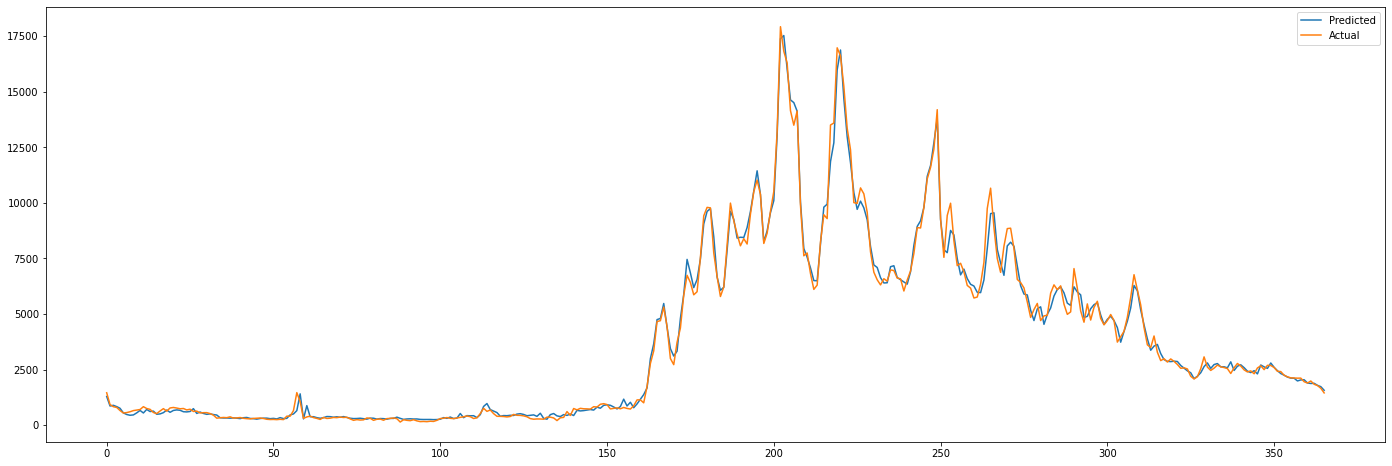

In [39]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [40]:
model_pred_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

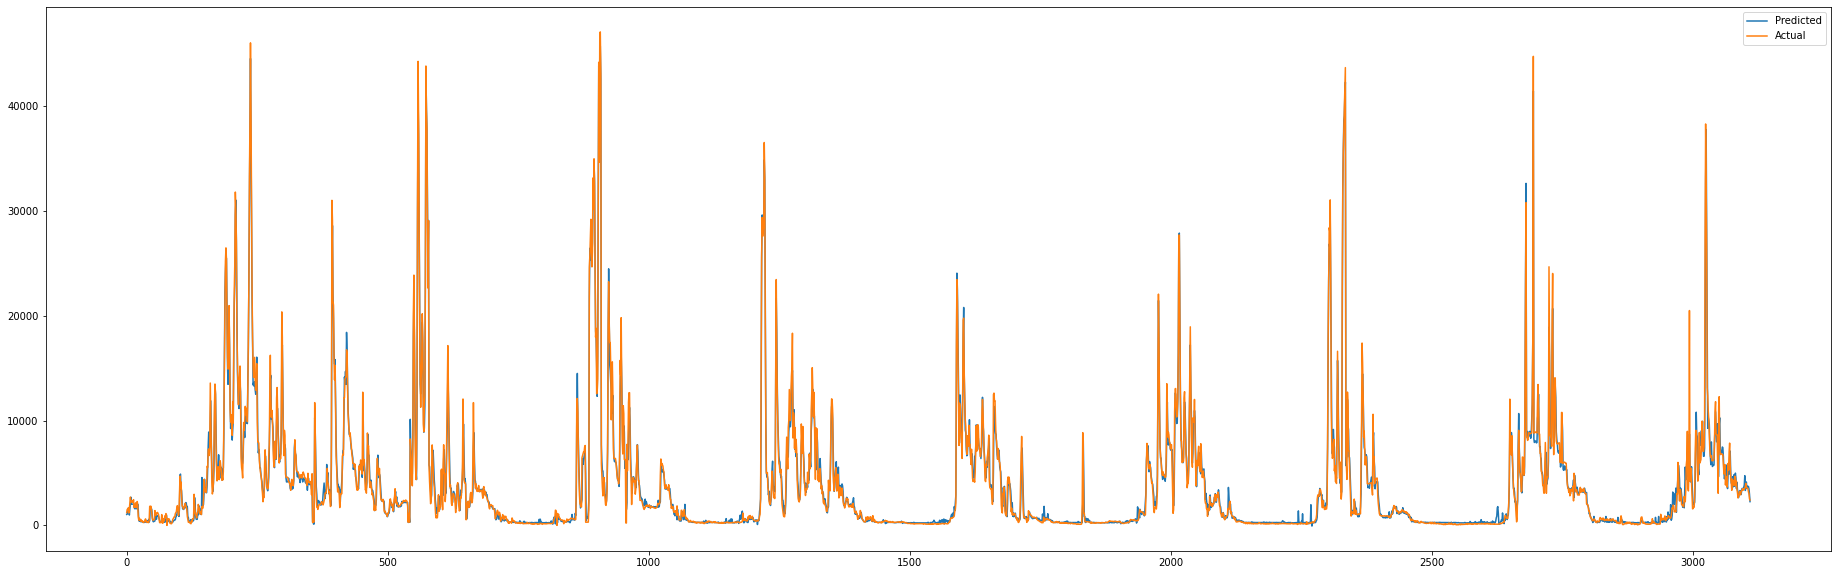

In [41]:
plt.figure(figsize=(32, 10))
plt.plot(model_pred_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_pred_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

### Check Feature Importance (Skipped)

In [ ]:
feature_list = [['Month', 'Date', 'Season']] + [[f'{day_region}_temp', f'{day_region}_feels_like', f'{day_region}_temp_min', f'{day_region}_temp_max', f'{day_region}_pressure', f'{day_region}_humidity',
                                                 f'{day_region}_wind_speed', f'{day_region}_wind_deg', f'{day_region}_rain', f'{day_region}_clouds_all', f'{day_region}_broken clouds', f'{day_region}_overcast clouds',
                                                 f'{day_region}_scattered clouds', f'{day_region}_sky is clear', f'{day_region}_few clouds', f'{day_region}_fog', f'{day_region}_light rain', f'{day_region}_mist',
                                                 f'{day_region}_haze', f'{day_region}_moderate rain', f'{day_region}_heavy intensity rain', f'{day_region}_light intensity drizzle', f'{day_region}_drizzle',
                                                 f'{day_region}_heavy intensity drizzle', f'{day_region}_very heavy rain', f'{day_region}_thunderstorm with heavy rain', f'{day_region}_thunderstorm with rain',
                                                 f'{day_region}_thunderstorm', f'{day_region}_proximity shower rain', f'{day_region}_thunderstorm with light rain', f'{day_region}_shower rain',
                                                 f'{day_region}_light intensity shower rain', f'{day_region}_light thunderstorm'] for day_region in ['1_mysuru', '2_mysuru', '1_kodagu', '2_kodagu', '1_hassan', '2_hassan']]
feature_list = feature_list[0] + feature_list[1] + feature_list[2] + feature_list[3] + feature_list[4] + feature_list[5] + feature_list[6]
len(feature_list)

201

In [ ]:
feature_list

['Month',
 'Date',
 'Season',
 '1_mysuru_temp',
 '1_mysuru_feels_like',
 '1_mysuru_temp_min',
 '1_mysuru_temp_max',
 '1_mysuru_pressure',
 '1_mysuru_humidity',
 '1_mysuru_wind_speed',
 '1_mysuru_wind_deg',
 '1_mysuru_rain',
 '1_mysuru_clouds_all',
 '1_mysuru_broken clouds',
 '1_mysuru_overcast clouds',
 '1_mysuru_scattered clouds',
 '1_mysuru_sky is clear',
 '1_mysuru_few clouds',
 '1_mysuru_fog',
 '1_mysuru_light rain',
 '1_mysuru_mist',
 '1_mysuru_haze',
 '1_mysuru_moderate rain',
 '1_mysuru_heavy intensity rain',
 '1_mysuru_light intensity drizzle',
 '1_mysuru_drizzle',
 '1_mysuru_heavy intensity drizzle',
 '1_mysuru_very heavy rain',
 '1_mysuru_thunderstorm with heavy rain',
 '1_mysuru_thunderstorm with rain',
 '1_mysuru_thunderstorm',
 '1_mysuru_proximity shower rain',
 '1_mysuru_thunderstorm with light rain',
 '1_mysuru_shower rain',
 '1_mysuru_light intensity shower rain',
 '1_mysuru_light thunderstorm',
 '2_mysuru_temp',
 '2_mysuru_feels_like',
 '2_mysuru_temp_min',
 '2_mysuru_

In [ ]:
r = permutation_importance(model, X_val, y_val,
                           n_repeats=10,
                           random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]
plt.figure(figsize=(32, 10))
plt.boxplot(r.importances[sort_idx].T, labels=feature_list)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(f"{feature_list[i]:10s}: {r.importances_mean[i]:.3f} +/- "
          f"{r.importances_std[i]:.3f}")

KeyboardInterrupt: 

In [ ]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {feature_list[i]}, Score: %.5f' % (v))
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar(feature_list, [x for x in range(len(importance))])
plt.show()

### Save Model

In [42]:
import pickle
with open('encoders/month_le.pkl', 'wb') as f:
    pickle.dump(month_le, f)

with open('encoders/season_le.pkl', 'wb') as f:
    pickle.dump(season_le, f)

with open('encoders/date_le.pkl', 'wb') as f:
    pickle.dump(date_le, f)

In [43]:
with open('encoders/rs_inflow.pkl', 'wb') as f:
    pickle.dump(rs_inflow, f)

with open('encoders/rs_temp.pkl', 'wb') as f:
    pickle.dump(rs_temp, f)

with open('encoders/rs_feels_like.pkl', 'wb') as f:
    pickle.dump(rs_feels_like, f)

with open('encoders/rs_temp_min.pkl', 'wb') as f:
    pickle.dump(rs_temp_min, f)

with open('encoders/rs_temp_max.pkl', 'wb') as f:
    pickle.dump(rs_temp_max, f)

with open('encoders/rs_pressure.pkl', 'wb') as f:
    pickle.dump(rs_pressure, f)

with open('encoders/rs_humidity.pkl', 'wb') as f:
    pickle.dump(rs_humidity, f)

with open('encoders/rs_wind_speed.pkl', 'wb') as f:
    pickle.dump(rs_wind_speed, f)

with open('encoders/rs_wind_deg.pkl', 'wb') as f:
    pickle.dump(rs_wind_deg, f)

with open('encoders/rs_rain.pkl', 'wb') as f:
    pickle.dump(rs_rain, f)

with open('encoders/rs_clouds_all.pkl', 'wb') as f:
    pickle.dump(rs_clouds_all, f)

In [44]:
model.save_model("inflow_xgboost.json")

In [30]:
model = XGBRegressor()
model.load_model("inflow_xgboost.json")

In [35]:
import datetime

In [100]:
xx = train_emb_df.copy()
# xx.index = xx.index.astype(str)

In [101]:
x = xx[(xx.index >= datetime.date(2011, 6, 1)) & (xx.index < datetime.date(2011, 12, 31))]

In [102]:
x

,0,1,2,3,4,5,6,7,8,9,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
2011-06-01,5.0,0.0,1.0,1.132,1.102389,0.718310,0.748214,-0.548043,-0.555872,0.509434,...,-0.136566,-0.169096,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370
2011-06-02,5.0,1.0,1.0,1.232,1.389078,0.862676,1.017857,-0.487544,-0.351767,0.069182,...,-0.169096,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626
2011-06-03,5.0,2.0,1.0,0.980,1.150171,0.419014,0.873214,-0.679715,-0.135690,0.132075,...,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837
2011-06-04,5.0,3.0,1.0,0.924,1.071672,0.778169,0.926786,-0.829181,-0.095211,-0.308176,...,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495
2011-06-05,5.0,4.0,1.0,1.084,1.242321,0.816901,1.025000,-0.814947,-0.216078,0.100629,...,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495,-0.003580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-26,11.0,25.0,2.0,-0.752,-0.832765,-1.869718,-0.403571,0.800712,-0.700684,0.408805,...,0.636796,0.578692,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514
2011-12-27,11.0,26.0,2.0,-1.304,-1.368601,-2.105634,-0.562500,0.950178,-0.871722,0.377358,...,0.578692,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239
2011-12-28,11.0,27.0,2.0,-1.196,-1.249147,-1.767606,-0.569643,1.010676,-0.726910,0.389937,...,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086
2011-12-29,11.0,28.0,2.0,-1.060,-1.075085,-1.707746,-0.487500,0.711744,-0.401938,-0.188679,...,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,0.511585


In [103]:
model.predict(x.iloc[:, :-1])

array([-0.12709798, -0.08837368, -0.12713307,  0.59256375,  0.10746586,
        0.04143139,  0.06715754,  0.28358996,  0.5586081 ,  0.38405803,
        0.38273835,  0.30084723,  0.2953113 ,  0.43851805,  0.77212507,
        1.2108681 ,  1.4795039 ,  1.178387  ,  1.2731228 ,  1.7268869 ,
        2.0879178 ,  1.2816591 ,  0.7821535 ,  0.51387596,  0.3216207 ,
        0.47625908,  0.7220353 ,  1.6427995 ,  2.4028318 ,  2.2128708 ,
        1.4888774 ,  0.8977967 ,  0.6203311 ,  0.5638411 ,  0.76392084,
        1.0352284 ,  0.75465363,  0.5784772 ,  0.7425273 ,  0.8008594 ,
        0.7503913 ,  0.62670404,  0.540588  ,  0.76548785,  0.7813681 ,
        1.4306083 ,  2.6926937 ,  4.190247  ,  4.596367  ,  4.8664217 ,
        4.8727207 ,  3.9782658 ,  2.7880201 ,  2.4098835 ,  3.11512   ,
        3.793973  ,  3.1187449 ,  2.0580685 ,  1.5474883 ,  1.8074288 ,
        1.724452  ,  1.3223679 ,  1.5283524 ,  1.6782593 ,  3.0046618 ,
        4.009499  ,  4.359809  ,  5.7108245 ,  6.005491  ,  5.20

In [104]:
x['pred'] = model.predict(x.iloc[:, :-1])

/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [105]:
x

,0,1,2,3,4,5,6,7,8,9,...,1094,1095,1096,1097,1098,1099,1100,1101,1102,pred
2011-06-01,5.0,0.0,1.0,1.132,1.102389,0.718310,0.748214,-0.548043,-0.555872,0.509434,...,-0.169096,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.127098
2011-06-02,5.0,1.0,1.0,1.232,1.389078,0.862676,1.017857,-0.487544,-0.351767,0.069182,...,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.088374
2011-06-03,5.0,2.0,1.0,0.980,1.150171,0.419014,0.873214,-0.679715,-0.135690,0.132075,...,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,-0.127133
2011-06-04,5.0,3.0,1.0,0.924,1.071672,0.778169,0.926786,-0.829181,-0.095211,-0.308176,...,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495,0.592564
2011-06-05,5.0,4.0,1.0,1.084,1.242321,0.816901,1.025000,-0.814947,-0.216078,0.100629,...,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495,-0.003580,0.107466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-26,11.0,25.0,2.0,-0.752,-0.832765,-1.869718,-0.403571,0.800712,-0.700684,0.408805,...,0.578692,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.508463
2011-12-27,11.0,26.0,2.0,-1.304,-1.368601,-2.105634,-0.562500,0.950178,-0.871722,0.377358,...,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.453348
2011-12-28,11.0,27.0,2.0,-1.196,-1.249147,-1.767606,-0.569643,1.010676,-0.726910,0.389937,...,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,0.460525
2011-12-29,11.0,28.0,2.0,-1.060,-1.075085,-1.707746,-0.487500,0.711744,-0.401938,-0.188679,...,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,0.511585,0.461640


<AxesSubplot:>

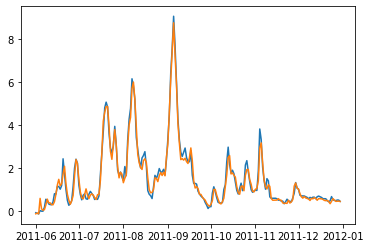

In [106]:
x[1102].plot()
x['pred'].plot()

In [107]:
x['pred'] = rs_inflow.inverse_transform([x['pred']]).flatten()
x['true'] = rs_inflow.inverse_transform([x[1102]]).flatten()

/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [108]:
x

,0,1,2,3,4,5,6,7,8,9,...,1095,1096,1097,1098,1099,1100,1101,1102,pred,true
2011-06-01,5.0,0.0,1.0,1.132,1.102389,0.718310,0.748214,-0.548043,-0.555872,0.509434,...,-0.196921,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,1048.276852,1306.0
2011-06-02,5.0,1.0,1.0,1.232,1.389078,0.862676,1.017857,-0.487544,-0.351767,0.069182,...,-0.090942,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,1237.551529,1163.0
2011-06-03,5.0,2.0,1.0,0.980,1.150171,0.419014,0.873214,-0.679715,-0.135690,0.132075,...,-0.098921,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,1048.105330,1030.0
2011-06-04,5.0,3.0,1.0,0.924,1.071672,0.778169,0.926786,-0.829181,-0.095211,-0.308176,...,0.067823,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495,4565.803461,1799.0
2011-06-05,5.0,4.0,1.0,1.084,1.242321,0.816901,1.025000,-0.814947,-0.216078,0.100629,...,0.021789,-0.006649,-0.111196,-0.074370,-0.103626,-0.130837,0.026495,-0.003580,2194.766273,1652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-26,11.0,25.0,2.0,-0.752,-0.832765,-1.869718,-0.403571,0.800712,-0.700684,0.408805,...,0.578487,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,4154.738694,4111.0
2011-12-27,11.0,26.0,2.0,-1.304,-1.368601,-2.105634,-0.562500,0.950178,-0.871722,0.377358,...,0.575418,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,3885.350574,4051.0
2011-12-28,11.0,27.0,2.0,-1.196,-1.249147,-1.767606,-0.569643,1.010676,-0.726910,0.389937,...,0.484579,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,3920.431827,4192.0
2011-12-29,11.0,28.0,2.0,-1.060,-1.075085,-1.707746,-0.487500,0.711744,-0.401938,-0.188679,...,0.436499,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,0.511585,3925.880183,4170.0
